## Calculate balanced machine learning measures, Full Data Set, All 6 analyses

From request [Calculate balanced machine learning measures](https://trello.com/c/fGlOzVVt)

Set `average='weighted'` in calulating metrics

## Imports and Function Definitions

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model,X,y,average='weighted')
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [3]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

In [4]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.2s finished


Best parameters set found on development set:

{'classifier__C': 0.08858667904100832}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        55
         1.0       0.99      0.92      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.94      0.92       201
weighted avg       0.94      0.94      0.94       201




TypeError: __call__() got an unexpected keyword argument 'average'

In [6]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.12080855369567871	0.004835873249778027
score_time	0.024393796920776367	0.0007995218797017059
test_recall	0.944632683658171	0.012922512021090755
train_recall	0.9628042224154534	0.005182957057523691
test_precision	0.9838934863545159	0.008758594918601271
train_precision	0.9915443205057519	0.002569577080870169
test_auc	0.9521648266775703	0.011504948454974982
train_auc	0.9707499236488791	0.003896120022495972
test_specificity	0.9596969696969697	0.022149559808129576
train_specificity	0.9786956248823049	0.006538989715759823
test_npv	0.8707350534321747	0.02547843480431107
train_npv	0.9104797229751191	0.011433809938486798
test_accuracy	0.9488183132153599	0.009931006616613992
train_accuracy	0.9672293613707165	0.00394008264747232


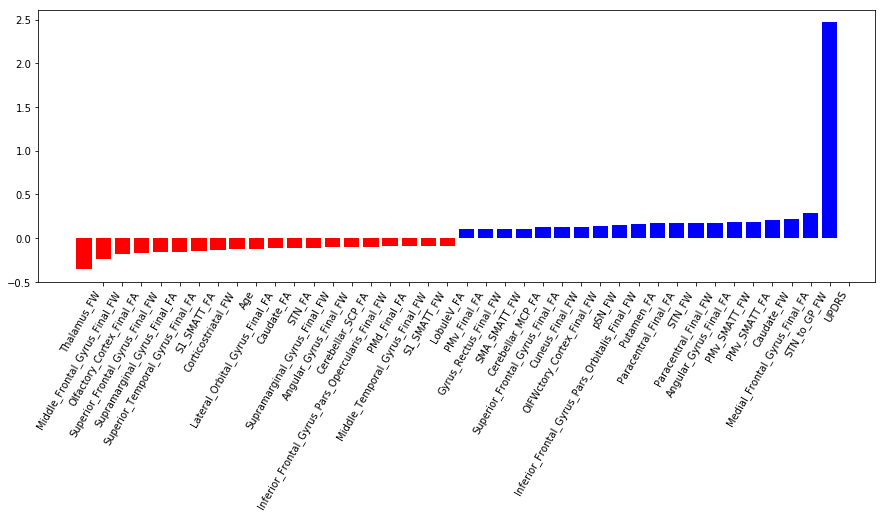

Age	-0.13068225177321086
Sex	-0.027056453961169607
UPDRS	2.4697864790280417
aSN_FA	-0.027253414948241884
Caudate_FA	-0.11924903211696951
CC2_FA	0.09714227403580246
GP_FA	-0.07873203015024519
LobuleVI_FA	0.09989439173370343
LobuleV_FA	-0.0884594354481196
MCP_FA	0.003902292722719872
pSN_FA	0.09856403298842283
Putamen_FA	0.15471732026088547
SCP_FA	0.08172765725928492
STN_FA	-0.11447550822774594
Thalamus_FA	0.09369552630242634
Vermis_FA	0.033438841695330214
RN_FA	-0.006986439342775639
PPN_FA	-0.006165860263182798
Dentate_FA	-0.05187559318864855
CC1_FA	-0.07275122045505103
aSN_FW	-0.05125869934871909
Caudate_FW	0.20544113546015558
CC2_FW	-0.02219687812250189
GP_FW	-0.0884040790316512
LobuleVI_FW	0.015892065861311252
LobuleV_FW	-0.06181628699988309
MCP_FW	-0.019652777006473637
pSN_FW	0.14232347385103739
Putamen_FW	-0.04765749780566221
SCP_FW	0.0906722658978428
STN_FW	0.17621562207019065
Thalamus_FW	-0.3579473734710621
Vermis_FW	-0.008173307502019849
RN_FW	0.0010898423117052696
PPN_FW	0.07447

In [7]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        55
         1.0       0.99      0.92      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.94      0.92       201
weighted avg       0.94      0.94      0.94       201



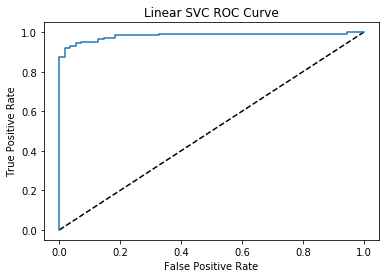

0.0 0.0
0.0 0.0684931506849315
0.0 0.8767123287671232
0.01818181818181818 0.8767123287671232
0.01818181818181818 0.9178082191780822
0.03636363636363636 0.9178082191780822
0.03636363636363636 0.9315068493150684
0.05454545454545454 0.9315068493150684
0.05454545454545454 0.9452054794520548
0.07272727272727272 0.9452054794520548
0.07272727272727272 0.952054794520548
0.12727272727272726 0.952054794520548
0.12727272727272726 0.9657534246575342
0.14545454545454545 0.9657534246575342
0.14545454545454545 0.9726027397260274
0.18181818181818182 0.9726027397260274
0.18181818181818182 0.9863013698630136
0.32727272727272727 0.9863013698630136
0.32727272727272727 0.9931506849315068
0.9454545454545454 0.9931506849315068
0.9454545454545454 1.0
1.0 1.0


In [8]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [9]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94       105
         1.0       0.79      0.93      0.85        40

   micro avg       0.91      0.91      0.91       145
   macro avg       0.88      0.91      0.89       145
weighted avg       0.92      0.91      0.91       145


recall	0.925
precision	0.7872340425531915
auc	0.9148809523809524
specificity	0.9047619047619048
npv	0.9693877551020408
accuracy	0.9103448275862069


In [10]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.060800600051879886	0.002787360837880497
score_time	0.019800376892089844	0.0011673979602893226
test_recall	0.7922689075630253	0.05780730844156144
train_recall	0.8742988218121155	0.011490080403828396
test_precision	0.7911123138986916	0.056996326996631826
train_precision	0.8797245227614304	0.01654964898889797
test_auc	0.850590942790847	0.028409629240800673
train_auc	0.9115948050181185	0.005136598909860371
test_specificity	0.908912978018669	0.02861344769638586
train_specificity	0.9488907882241214	0.008169120986289597
test_npv	0.9118758369990003	0.02256221324138854
train_npv	0.9465975046270522	0.004502725052474623
test_accuracy	0.8739981291405579	0.022336869827276392
train_accuracy	0.926593662475654	0.004980202311207713


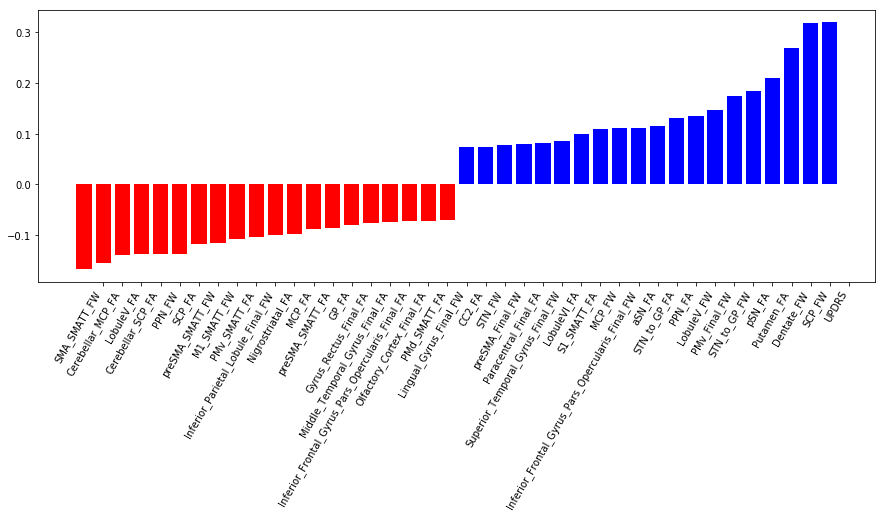

Age	-0.040612611273845856
Sex	0.0
UPDRS	0.32018775038962266
aSN_FA	0.11092836952223868
Caudate_FA	-0.04454439279477706
CC2_FA	0.07311341953557758
GP_FA	-0.08595982894367805
LobuleVI_FA	0.08585818131489262
LobuleV_FA	-0.1398570697100289
MCP_FA	-0.09765968687060948
pSN_FA	0.18404493085541976
Putamen_FA	0.20903042677531664
SCP_FA	-0.13737332986933345
STN_FA	0.0592858737686049
Thalamus_FA	-0.0405980946063273
Vermis_FA	0.06921835976806265
RN_FA	-0.023659016324588066
PPN_FA	0.13121649579492817
Dentate_FA	0.05920276725396031
CC1_FA	0.0026151227250670213
aSN_FW	0.037385718773037674
Caudate_FW	0.03765217661514081
CC2_FW	-0.03927940242239305
GP_FW	0.041158729405691444
LobuleVI_FW	-0.03394727396998129
LobuleV_FW	0.13499124522817668
MCP_FW	0.10883286212879704
pSN_FW	0.0258832491701722
Putamen_FW	0.029078520722542925
SCP_FW	0.3184509504776658
STN_FW	0.07312934959531746
Thalamus_FW	0.05689108742069675
Vermis_FW	0.053789542426698984
RN_FW	-0.015732940570522092
PPN_FW	-0.13739550906063333
Dentate_FW	0

In [11]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94       105
         1.0       0.79      0.93      0.85        40

   micro avg       0.91      0.91      0.91       145
   macro avg       0.88      0.91      0.89       145
weighted avg       0.92      0.91      0.91       145



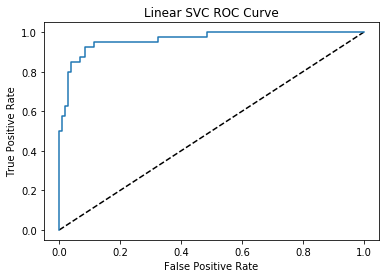

0.0 0.0
0.0 0.025
0.0 0.5
0.009523809523809525 0.5
0.009523809523809525 0.575
0.01904761904761905 0.575
0.01904761904761905 0.625
0.02857142857142857 0.625
0.02857142857142857 0.8
0.0380952380952381 0.8
0.0380952380952381 0.85
0.06666666666666667 0.85
0.06666666666666667 0.875
0.08571428571428572 0.875
0.08571428571428572 0.925
0.11428571428571428 0.925
0.11428571428571428 0.95
0.3238095238095238 0.95
0.3238095238095238 0.975
0.4857142857142857 0.975
0.4857142857142857 1.0
1.0 1.0


In [12]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [13]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


Best parameters set found on development set:

{'classifier__C': 0.002335721469090121}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90       131
         1.0       0.35      0.86      0.50        14

   micro avg       0.83      0.83      0.83       145
   macro avg       0.67      0.84      0.70       145
weighted avg       0.92      0.83      0.86       145


recall	0.8571428571428571
precision	0.35294117647058826
auc	0.8446019629225735
specificity	0.8320610687022901
npv	0.9819819819819819
accuracy	0.8344827586206897


In [14]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.09619274139404296	0.003923786444428386
score_time	0.03140492439270019	0.0014968201654943399
test_recall	0.6714285714285715	0.08571428571428573
train_recall	0.8071428571428572	0.013363062095621207
test_precision	0.5432018961430727	0.12413742967951034
train_precision	0.6059541832357574	0.04860517768861733
test_auc	0.7944310397426297	0.050186939220720636
train_auc	0.8669771471242059	0.013500237052874625
test_specificity	0.917433508056688	0.029008949387191972
train_specificity	0.9268114371055548	0.014216312141181981
test_npv	0.9530444582587256	0.012252041026092451
train_npv	0.9721503283458299	0.002288393255003297
test_accuracy	0.8877061469265367	0.03097104380940314
train_accuracy	0.9123435987189991	0.013998925691611841


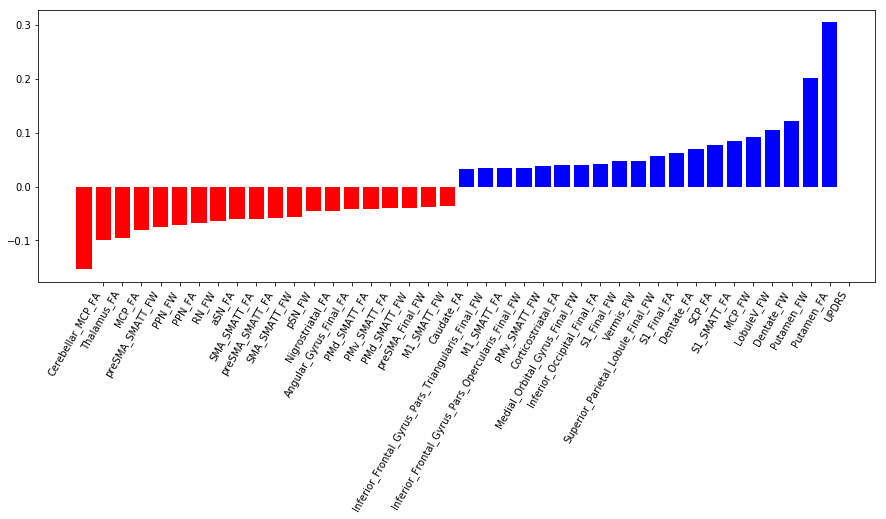

Age	-0.0030738142433390236
Sex	0.0
UPDRS	0.30451647699559
aSN_FA	-0.0644839007907951
Caudate_FA	-0.036593470767822274
CC2_FA	0.01826334498306767
GP_FA	0.029503767937568082
LobuleVI_FA	-0.03382269828263507
LobuleV_FA	-0.03616122866685263
MCP_FA	-0.09574219907443526
pSN_FA	-0.01653451826749927
Putamen_FA	0.20198185438341165
SCP_FA	0.0704173178945833
STN_FA	-0.027138062211862296
Thalamus_FA	-0.09960902308216792
Vermis_FA	-0.010733839247185864
RN_FA	-0.011396937149034746
PPN_FA	-0.07163287094682547
Dentate_FA	0.06288955609363085
CC1_FA	-0.011823428417248052
aSN_FW	-0.005403639272111569
Caudate_FW	0.0020493943310174734
CC2_FW	-0.02694870929002994
GP_FW	0.03139221356047883
LobuleVI_FW	0.01458309406525968
LobuleV_FW	0.0912574963540033
MCP_FW	0.08488644645313206
pSN_FW	-0.057289926627003045
Putamen_FW	0.12198167232401914
SCP_FW	-0.0011577215139479714
STN_FW	-0.006000944232667175
Thalamus_FW	0.020924625708383156
Vermis_FW	0.046433272623757994
RN_FW	-0.0670518336672297
PPN_FW	-0.0758335904158096

In [15]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90       131
         1.0       0.35      0.86      0.50        14

   micro avg       0.83      0.83      0.83       145
   macro avg       0.67      0.84      0.70       145
weighted avg       0.92      0.83      0.86       145



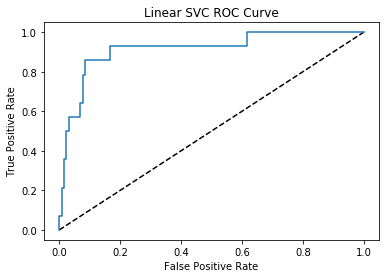

0.0 0.0
0.0 0.07142857142857142
0.007633587786259542 0.07142857142857142
0.007633587786259542 0.21428571428571427
0.015267175572519083 0.21428571428571427
0.015267175572519083 0.35714285714285715
0.022900763358778626 0.35714285714285715
0.022900763358778626 0.5
0.030534351145038167 0.5
0.030534351145038167 0.5714285714285714
0.06870229007633588 0.5714285714285714
0.06870229007633588 0.6428571428571429
0.07633587786259542 0.6428571428571429
0.07633587786259542 0.7857142857142857
0.08396946564885496 0.7857142857142857
0.08396946564885496 0.8571428571428571
0.16793893129770993 0.8571428571428571
0.16793893129770993 0.9285714285714286
0.6183206106870229 0.9285714285714286
0.6183206106870229 1.0
1.0 1.0


In [16]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [17]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       119
         1.0       0.78      0.81      0.79        26

   micro avg       0.92      0.92      0.92       145
   macro avg       0.87      0.88      0.87       145
weighted avg       0.93      0.92      0.92       145


recall	0.8076923076923077
precision	0.7777777777777778
auc	0.8786360698125404
specificity	0.9495798319327731
npv	0.9576271186440678
accuracy	0.9241379310344827


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [18]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.05379953384399414	0.0036551108660648262
score_time	0.01900005340576172	0.001267385006471109
test_recall	0.8166666666666667	0.053111784737518826
train_recall	0.9078166323831913	0.02218340634893391
test_precision	0.8384210526315791	0.09265530164026496
train_precision	0.8816322050042981	0.034731465673902145
test_auc	0.8904934210526315	0.035672003314667584
train_auc	0.9405114381697695	0.01008668888042045
test_specificity	0.9643201754385965	0.021590755933192738
train_specificity	0.9732062439563476	0.00918933879707767
test_npv	0.9601918703316746	0.012313708521009959
train_npv	0.9799450995611638	0.0046869396926505205
test_accuracy	0.9379437204474685	0.026211977976446144
train_accuracy	0.9615652234610306	0.006925309895526089


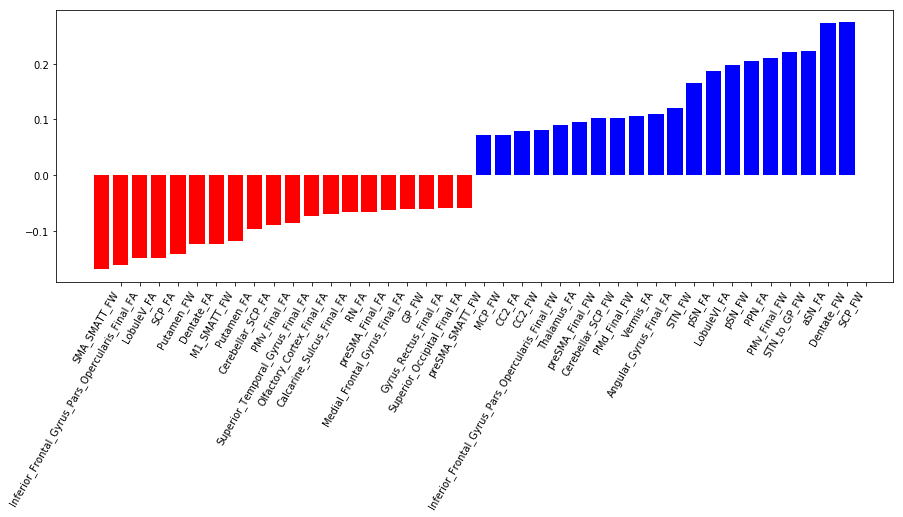

Age	0.04795173772621195
Sex	0.0
UPDRS	-0.03169670960949488
aSN_FA	0.22334296030467843
Caudate_FA	-0.0019270321601898327
CC2_FA	0.0725715024703237
GP_FA	-0.05063293534718346
LobuleVI_FA	0.1872036176024281
LobuleV_FA	-0.14884907012518384
MCP_FA	0.04339224443110459
pSN_FA	0.16493257519269866
Putamen_FA	-0.11896491904943993
SCP_FA	-0.14826740951290637
STN_FA	0.05929734261668187
Thalamus_FA	0.08930143565926428
Vermis_FA	0.10518855823133548
RN_FA	-0.06614409247135145
PPN_FA	0.20547761956484567
Dentate_FA	-0.1242867849493785
CC1_FA	0.02260784962690032
aSN_FW	0.027373077765827446
Caudate_FW	0.019408112043125637
CC2_FW	0.07910530215569855
GP_FW	-0.06176833412137448
LobuleVI_FW	-0.0322801030488372
LobuleV_FW	-0.01817354375199714
MCP_FW	0.07220329715336343
pSN_FW	0.1973638351547453
Putamen_FW	-0.14113322890372226
SCP_FW	0.27457648245120353
STN_FW	0.11999801494481316
Thalamus_FW	0.03180342041163815
Vermis_FW	0.004427553138980432
RN_FW	0.01843344487632428
PPN_FW	0.022292606069243947
Dentate_FW	0.27

In [19]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       119
         1.0       0.78      0.81      0.79        26

   micro avg       0.92      0.92      0.92       145
   macro avg       0.87      0.88      0.87       145
weighted avg       0.93      0.92      0.92       145



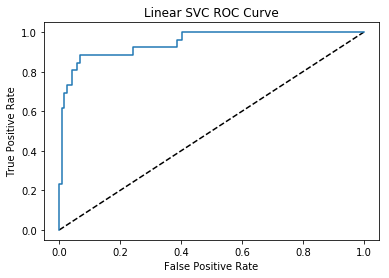

0.0 0.0
0.0 0.038461538461538464
0.0 0.23076923076923078
0.008403361344537815 0.23076923076923078
0.008403361344537815 0.6153846153846154
0.01680672268907563 0.6153846153846154
0.01680672268907563 0.6923076923076923
0.025210084033613446 0.6923076923076923
0.025210084033613446 0.7307692307692307
0.04201680672268908 0.7307692307692307
0.04201680672268908 0.8076923076923077
0.058823529411764705 0.8076923076923077
0.058823529411764705 0.8461538461538461
0.06722689075630252 0.8461538461538461
0.06722689075630252 0.8846153846153846
0.24369747899159663 0.8846153846153846
0.24369747899159663 0.9230769230769231
0.3865546218487395 0.9230769230769231
0.3865546218487395 0.9615384615384616
0.40336134453781514 0.9615384615384616
0.40336134453781514 1.0
1.0 1.0


In [20]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

In [3]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    8.9s remaining:    1.5s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43


recall	0.833333333333
precision	0.892857142857
auc	0.801282051282
specificity	0.769230769231
npv	0.666666666667
accuracy	0.813953488372


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished


In [4]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0111249446869	0.00112801220998
score_time	0.00650248527527	0.000891476884707
test_recall	0.858947368421	0.0729398492365
train_recall	0.881234177215	0.0263255383405
test_precision	0.923698830409	0.0264310503776
train_precision	0.986255086072	0.0122710423822
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.900952380952	0.0358125631942
train_specificity	0.982330827068	0.0158331734056
test_npv	0.826587301587	0.078020353825
train_npv	0.856753770423	0.0255876012875
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634


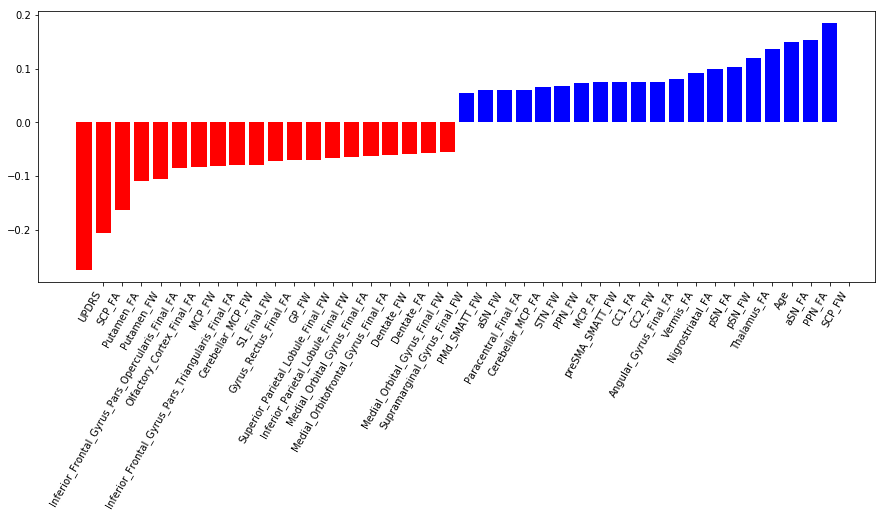

Age	0.136385091108
Sex	0.0408123164569
UPDRS	-0.274976658545
aSN_FA	0.149135031144
Caudate_FA	0.0193797749595
CC2_FA	0.0248632210564
GP_FA	-0.0264047804513
LobuleVI_FA	0.0382352213832
LobuleV_FA	-0.0458763629965
MCP_FA	0.0743042979131
pSN_FA	0.0987483199736
Putamen_FA	-0.162424527963
SCP_FA	-0.205717807841
STN_FA	0.051329541284
Thalamus_FA	0.120659934842
Vermis_FA	0.0807117121331
RN_FA	-0.0123614406316
PPN_FA	0.154129234307
Dentate_FA	-0.0591345261233
CC1_FA	0.0754134224956
aSN_FW	0.0600026486026
Caudate_FW	0.0116718481648
CC2_FW	0.0757994586719
GP_FW	-0.0697233298565
LobuleVI_FW	0.0180492676601
LobuleV_FW	-0.0221203395051
MCP_FW	-0.0831810525834
pSN_FW	0.103091874529
Putamen_FW	-0.109811747783
SCP_FW	0.18549290771
STN_FW	0.0660217555143
Thalamus_FW	0.0426365099806
Vermis_FW	-0.0272819392868
RN_FW	0.0451764130632
PPN_FW	0.0688197872224
Dentate_FW	-0.0601393450813
CC1_FW	0.0171111268717
Angular_Gyrus_Final_FA	0.0759778822611
Anterior_Orbital_Gyrus_Final_FA	-0.0391670044483
Calcarine_Sul

In [5]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43



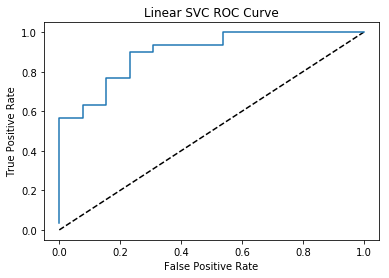

0.0 0.0333333333333
0.0 0.566666666667
0.0769230769231 0.566666666667
0.0769230769231 0.633333333333
0.153846153846 0.633333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.9
0.307692307692 0.9
0.307692307692 0.933333333333
0.538461538462 0.933333333333
0.538461538462 1.0
1.0 1.0


In [6]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

In [7]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43


recall	0.769230769231
precision	0.666666666667
auc	0.801282051282
specificity	0.833333333333
npv	0.892857142857
accuracy	0.813953488372


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished


In [8]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0106036663055	0.00102236705668
score_time	0.00640201568604	0.000490099090724
test_recall	0.900952380952	0.0358125631942
train_recall	0.982330827068	0.0158331734056
test_precision	0.826587301587	0.078020353825
train_precision	0.856753770423	0.0255876012875
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.858947368421	0.0729398492365
train_specificity	0.881234177215	0.0263255383405
test_npv	0.923698830409	0.0264310503776
train_npv	0.986255086072	0.0122710423822
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634


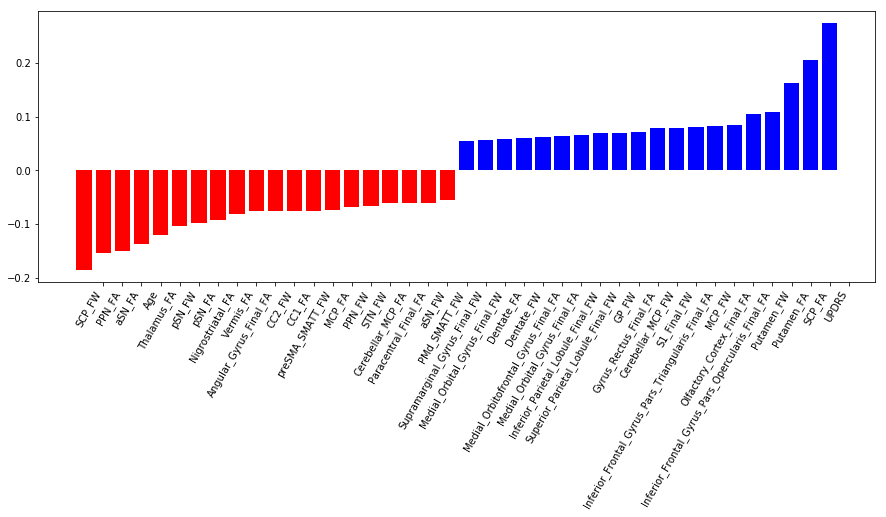

Age	-0.136409040829
Sex	-0.0408684239088
UPDRS	0.275024665333
aSN_FA	-0.149188410171
Caudate_FA	-0.0192993078021
CC2_FA	-0.0246956730561
GP_FA	0.0265136804937
LobuleVI_FA	-0.0381976313152
LobuleV_FA	0.0459978555446
MCP_FA	-0.0742755079312
pSN_FA	-0.0987578471785
Putamen_FA	0.162387844256
SCP_FA	0.205724218313
STN_FA	-0.051307521595
Thalamus_FA	-0.120684730605
Vermis_FA	-0.0809031018927
RN_FA	0.0124111194893
PPN_FA	-0.154205547056
Dentate_FA	0.0591106318817
CC1_FA	-0.0755776173622
aSN_FW	-0.0599536265546
Caudate_FW	-0.0115940011855
CC2_FW	-0.0758295551283
GP_FW	0.0697418831905
LobuleVI_FW	-0.0180495574067
LobuleV_FW	0.0220088302957
MCP_FW	0.0832207237751
pSN_FW	-0.103023628875
Putamen_FW	0.109834222454
SCP_FW	-0.185488485673
STN_FW	-0.0660084277757
Thalamus_FW	-0.0427216064969
Vermis_FW	0.0273440190972
RN_FW	-0.045285295148
PPN_FW	-0.0687590185557
Dentate_FW	0.0601093475301
CC1_FW	-0.0171509994711
Angular_Gyrus_Final_FA	-0.0760822622479
Anterior_Orbital_Gyrus_Final_FA	0.0392220985714
Ca

In [9]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43



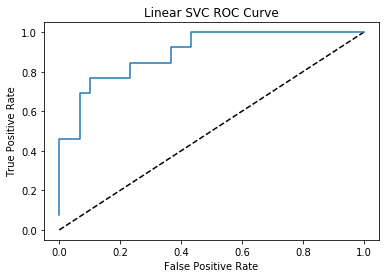

0.0 0.0769230769231
0.0 0.461538461538
0.0666666666667 0.461538461538
0.0666666666667 0.692307692308
0.1 0.692307692308
0.1 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.366666666667 0.846153846154
0.366666666667 0.923076923077
0.433333333333 0.923076923077
0.433333333333 1.0
1.0 1.0


In [10]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)